## Problem 1

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
data = pd.read_csv('problem1.csv')['x']
data

0     -0.002665
1     -0.045128
2      0.053635
3      0.010450
4     -0.016284
         ...   
495    0.009279
496   -0.001121
497    0.075188
498    0.038520
499   -0.033949
Name: x, Length: 500, dtype: float64

In [6]:
def ES(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    es = a[a<=v].mean()
    return -es

In [7]:
def VaR(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    return -v

In [8]:
norm_model = np.random.normal(data.mean(), data.std(), 10000)

Use MLE to fit general T distribution

In [9]:
def fit_general_t(x,n=10000):
    def t_fit(vals,r):
        nu = vals[0]
        miu = vals[1]
        s = vals[2]
        ll = stats.t.logpdf(r,df=nu,loc=miu,scale=s).sum()
        return -ll
    start_m = x.mean()
    start_nu = 6.0/stats.kurtosis(x) + 4
    start_s = math.sqrt(x.var()*start_nu/(start_nu-2))
    ll_t_res = minimize(t_fit,[start_nu,start_m,start_s],args=x,
    constraints=({'type':'ineq','fun': lambda vals: vals[0]-2.001},{'type':'ineq','fun': lambda vals: vals[2]-1e-6}))
    print(ll_t_res.message)
    nu,miu,s = ll_t_res.x[0],ll_t_res.x[1],ll_t_res.x[2]
    ysim = stats.t.rvs(df=nu,loc=miu,scale=s,size=n)
    return ysim

In [10]:
t_model = fit_general_t(data, n = 10000)

Optimization terminated successfully


Calculate the VaR and ES for normal distribution

In [11]:
var_n = VaR(norm_model)
es_n = ES(norm_model)

Calculate the VaR and ES for generized T distribution

In [12]:
var_t = VaR(t_model)
es_t = ES(t_model)

In [13]:
print("VaR for normal distribution:",var_n)
print("ES for normal distribution:",es_n)
print("VaR for generalized T distribution:",var_t)
print("ES for generalized T distribution:",es_t)

VaR for normal distribution: 0.08036471536552107
ES for normal distribution: 0.10145463599911116
VaR for generalized T distribution: 0.07485449134527764
ES for generalized T distribution: 0.11114132651018806


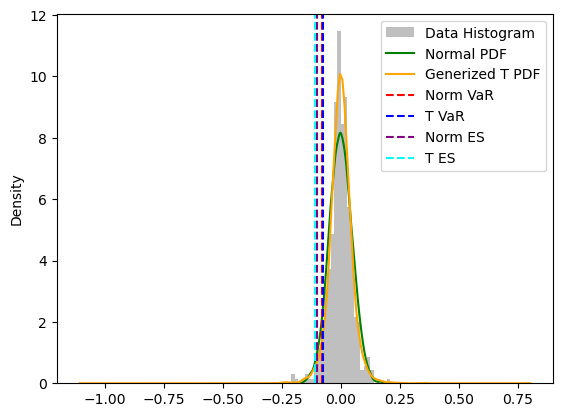

In [14]:
#Overlay the graphs the distribution PDFs, VaR, and ES values
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram', color='gray')
sns.kdeplot(norm_model,color="Green",label="Normal PDF")
sns.kdeplot(t_model,color="Orange",label="Generized T PDF")
plt.axvline(-var_n, color="Red",label="Norm VaR", linestyle="--")
plt.axvline(-var_t, color="blue",label="T VaR",linestyle="--")
plt.axvline(-es_n, color="purple",label="Norm ES", linestyle="--")
plt.axvline(-es_t, color="cyan",label="T ES",linestyle="--")
plt.legend()

Problem 3

In [15]:
def return_calculate(prices, method="DISCRETE", dateColumn="Date"):
    vars_ = prices.columns
    nVars = len(vars_)
    vars_ = [var for var in vars_ if var != dateColumn]
    if nVars == len(vars_):
        raise ValueError(f"dateColumn: {dateColumn} not in DataFrame: {vars_}")
    nVars = nVars - 1
    p = prices[vars_].to_numpy()
    n, m = p.shape
    p2 = np.empty((n-1, m))
    if method.upper() == "DISCRETE" or method.upper() == "LOG":
        for i in range(n - 1):
            for j in range(m):
                p2[i, j] = p[i + 1, j] / p[i, j]
        
        if method.upper() == "DISCRETE":
            p2 = p2 - 1.0
        else:
            p2 = np.log(p2)
    elif method.upper() == "CLASSIC":
        for i in range(n - 1):
            for j in range(m):
                p2[i, j] = p[i + 1, j] - p[i, j]
    else:
        raise ValueError(f"method: {method} must be in ('LOG', 'DISCRETE', 'CLASSIC')")
    dates = prices[dateColumn].iloc[1:n].to_numpy()
    out = pd.DataFrame({dateColumn: dates})
    for i in range(nVars):
        out[vars_[i]] = p2[:, i]
    return out

In [16]:
def get_portfolio_price(portfolio, prices, portfolio_code, Delta=False):
    if portfolio_code == "All":
        assets = portfolio.drop('Portfolio',axis=1)
        assets = assets.groupby(["Stock"], as_index=False)["Holding"].sum()
    else:
        assets = portfolio[portfolio["Portfolio"] == portfolio_code]        
    stock_codes = list(assets["Stock"])
    assets_prices = pd.concat([prices["Date"], prices[stock_codes]], axis=1)  
    current_price = np.dot(prices[assets["Stock"]].tail(1), assets["Holding"])
    holdings = assets["Holding"]    
    if Delta == True:
        asset_values = assets["Holding"].values.reshape(-1, 1) * prices[assets["Stock"]].tail(1).T.values
        delta = asset_values / current_price    
        return current_price, assets_prices, delta   
    return current_price, assets_prices, holdings

In [17]:
def MLE_T(params, returns):
    negLL = -1 * np.sum(stats.t.logpdf(returns, df=params[0], loc=params[1], scale=params[2]))
    return(negLL)

def Fitting_t_MLE(returns):
    constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, {"type":"ineq", "fun":lambda x: x[2]})
    returns_t = minimize(MLE_T, x0=[10, np.mean(returns), np.std(returns)], args=returns, constraints=constraints)
    df, loc, scale = returns_t.x[0], returns_t.x[1], returns_t.x[2]
    return df, loc, scale

In [18]:
def chol_psd(a):
    n= a.shape[0]
    root = np.zeros((n,n))
    for j in range(n):
        s=0
        if j>0:
            s = root[j,:j].T @ root[j,:j]
        temp = a[j,j] - s
        if temp <= 0 and temp >= -1e-8:
            temp =0
        root[j,j] = math.sqrt(temp)
        if root[j,j] == 0:
            root[j+1:n,j] = 0
        else:
            ir = 1/root[j,j]
            for i in range(j+1,n):
                s = root[i,:j].T @ root[j,:j]
                root[i,j] = (a[i,j]-s)*ir
    return root

In [19]:
def multivariate_normal_simulation(covariance_matrix, n_samples, method='direct', mean = 0, explained_variance=1.0):
    if method == 'direct':      
        L = chol_psd(covariance_matrix)
        normal_samples = np.random.normal(size=(covariance_matrix.shape[0], n_samples))       
        samples = np.transpose(np.dot(L, normal_samples) + mean)        
        return samples 
    elif method == 'pca':
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        idx = eigenvalues > 1e-8
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        if explained_variance == 1.0:
            explained_variance = (np.cumsum(eigenvalues)/np.sum(eigenvalues))[-1]
        n_components = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= explained_variance)[0][0] + 1
        eigenvectors = eigenvectors[:,:n_components]
        eigenvalues = eigenvalues[:n_components]
        normal_samples = np.random.normal(size=(n_components, n_samples))
        B = np.dot(eigenvectors, np.diag(np.sqrt(eigenvalues)))
        samples = np.transpose(np.dot(B, normal_samples))      
        return samples

In [20]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")
portfolio_code = ['A','B','C','All']

for code in portfolio_code:
    current_price, assets_prices, holdings = get_portfolio_price(portfolio,prices,code)
    assets_returns = return_calculate(assets_prices)
    assets_returns.drop('Date', axis=1, inplace=True)
    norm_assets_returns = assets_returns - assets_returns.mean()
    parameters = []
    assets_returns_cdf = pd.DataFrame()
    for stock in norm_assets_returns.columns.tolist():
        params = Fitting_t_MLE(norm_assets_returns[stock])
        parameters.append(params)
        assets_returns_cdf[stock] = stats.t.cdf(norm_assets_returns[stock],df=params[0], loc=params[1], scale = params[2])

    spearman_corr_matrix = assets_returns_cdf.corr(method='spearman')
    sim_sample = multivariate_normal_simulation(spearman_corr_matrix, 10000, method='pca')
    sim_sample = pd.DataFrame(sim_sample, columns=assets_returns.columns)

    sim_sample_cdf = pd.DataFrame()
    for stock in sim_sample.columns.tolist():
        sim_sample_cdf[stock] = stats.norm.cdf(sim_sample[stock],loc=0,scale=1)

    sim_returns = pd.DataFrame()
    for i, stock in enumerate(sim_sample.columns.tolist()):
        sim_returns[stock] = stats.t.ppf(sim_sample_cdf[stock], df=parameters[i][0], loc=parameters[i][1], scale = parameters[i][2])

    assets_prices.drop('Date', axis=1, inplace=True)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)

    var_T = VaR(sim_prices)
    # print(var_T)
    es_T = ES(sim_prices)
    
    print("For Portfolio {}," .format(code))
    print("Current price is {}".format(current_price[0]))
    print("VaR is {}" .format(var_T))
    print("ES is {}" .format(es_T))

For Portfolio A,
Current price is 1089316.1599400002
VaR is 21101.514264274967
ES is 28829.938783690228
For Portfolio B,
Current price is 574542.40515
VaR is 12117.686581360986
ES is 16642.984106046635


/Users/a24044/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2134: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


For Portfolio C,
Current price is 1387409.50752
VaR is 27345.034633758874
ES is 35952.76088108954


/var/folders/14/qnbmw8kx46x2ncgblvbvxh1m0000gn/T/ipykernel_60217/2171444780.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars_[i]] = p2[:, i]
/Users/a24044/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2134: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


For Portfolio All,
Current price is 3051268.07261
VaR is 57318.66575212944
ES is 76444.78913781076
